In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [3]:
torch.cuda.is_available()

True

In [5]:
import pycuda.driver as cuda
cuda.init()## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU
# Tesla K80

'GeForce RTX 2070'

In [6]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)
print(device)

cuda:0


In [39]:
#transform = transforms.Compose([transforms.ToTensor(), 
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                               ])

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)



# USED TO LOAD OUR TRAINING DATA BATCHES
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [40]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    #print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

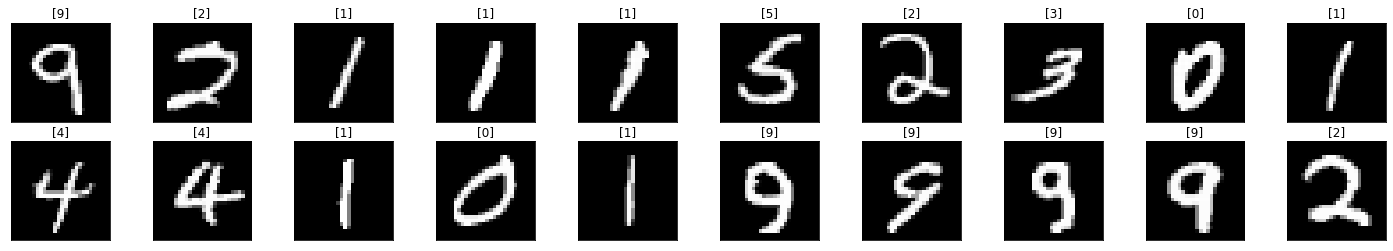

In [41]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [43]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x)) # relu is an activation f'n better than sigmoid for some things, CNNs
        x = F.relu(self.linear2(x))
        x = self.linear3(x)  # gives you the raw output "score" --> don't squash it
        return x

In [45]:
clfr = Classifier(784, 125, 65, 10)
model = clfr.cuda()
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [33]:
crit = nn.CrossEntropyLoss()
criterion = crit.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optm.cuda()

In [36]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0  
    
    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1) # Must flatten image to do mat mult: 1, 784
        inputs_cu = inputs.cuda()
        outputs = model(inputs_cu)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1) # Must flatten image to do mat mult: 1, 784
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
            
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch:', (e+1))
        print('training loss: {:.4f}, {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'target' in call to _thnn_nll_loss_forward

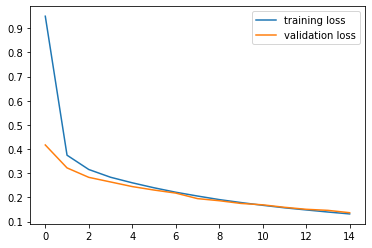

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

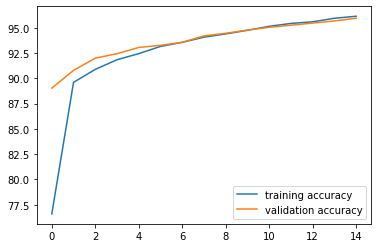

In [11]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()